# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, PrecisionRecallDisplay, accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import math
from google.colab import files
uploaded = files.upload()

Saving training_df.tsv to training_df.tsv


# Functions

## Feature Extraction

In [2]:
def sequence_composition(sequence:str) -> np.ndarray[np.float64]:
  sequence = sequence[:40]
  alphabet = "AQLSREKTNGMWDHFYCIPV"
  composition_matrix = np.zeros((20,40))
  composition_vector = np.zeros((20))
  for i in range(len(alphabet)):
    for j in range(len(sequence)):
      if alphabet[i] == sequence[j]:
        composition_matrix[i][j] += 1
        composition_vector[i] += composition_matrix[i][j]
  composition_vector = composition_vector/40
  return composition_vector

def hp_ai(sequence:str, window_size:int = 6 ) -> np.ndarray[np.float64]:
  kd_scale = {
    'R': -4.5,  # Arg
    'K': -3.9,  # Lys
    'N': -3.5,  # Asn
    'D': -3.5,  # Asp
    'Q': -3.5,  # Gln
    'E': -3.5,  # Glu
    'H': -3.2,  # His
    'P': -1.6,  # Pro
    'Y': -1.3,  # Tyr
    'W': -0.9,  # Trp
    'S': -0.8,  # Ser
    'T': -0.7,  # Thr
    'G': -0.4,  # Gly
    'A':  1.8,  # Ala
    'M':  1.9,  # Met
    'C':  2.5,  # Cys
    'F':  2.8,  # Phe
    'L':  3.8,  # Leu
    'V':  4.2,  # Val
    'I':  4.5   # Ile
    }

  a = 2.9 # relative volume of valine
  b = 3.9 # relative volume leucine/isoleucine

  sequence = sequence[:40]
  # padding to have as many scores as residues  (each window refers to the central res)
  d = int(window_size/2)
  sequence = "X"*d + sequence + "X"*d #padding
  hydrophobicities = np.array([])
  AIs = np.array([])  #aliphatic indexes
  for i in range(len(sequence)-(window_size)+1):
      counts_A = 0
      counts_V = 0
      counts_I = 0
      counts_L = 0
      hydrophobicity_score = 0
      window = sequence[i:i+window_size]
      for j in range(window_size):
        if window[j] != "X":
          hydrophobicity_score = (hydrophobicity_score + kd_scale[window[j]])
          if window[j] == 'A':
              counts_A += 1
          elif window[j] == 'V':
              counts_V += 1
          elif window[j] == 'I':
              counts_I += 1
          elif window[j] == 'L':
                counts_L += 1
      X_A = (counts_A / window_size)
      X_V = (counts_V / window_size)
      X_I = (counts_I / window_size)
      X_L = (counts_L / window_size)
      AI = X_A + a * X_V + b * (X_I + X_L) #Aliphatic Index Formula
      hydrophobicities = np.append(hydrophobicities, hydrophobicity_score / window_size)
      AIs = np.append(AIs, AI)
  H_AI = np.array([hydrophobicities.mean(), hydrophobicities.max(), np.argmax(hydrophobicities), AIs.mean(), AIs.max(), np.argmax(AIs)])
  return H_AI  #hydrophobicity and aliphatic index alltogether

def SSE(sequence,window_size):
  alpha_helix_scale = {
      "G": 0.570,  # Gly
      "P": 0.570,  # Pro
      "Y": 0.690,  # Tyr
      "C": 0.700,  # Cys
      "S": 0.770,  # Ser
      "T": 0.830,  # Thr
      "N": 0.670,  # Asn
      "R": 0.980,  # Arg
      "H": 1.000,  # His
      "D": 1.010,  # Asp
      "I": 1.080,  # Ile
      "W": 1.080,  # Trp
      "Q": 1.110,  # Gln
      "F": 1.130,  # Phe
      "K": 1.160,  # Lys
      "V": 1.060,  # Val
      "L": 1.210,  # Leu
      "A": 1.420,  # Ala
      "M": 1.450,  # Met
      "E": 1.510   # Glu
  }
  beta_sheet_scale = {
      "E": 0.370,  # Glu
      "D": 0.540,  # Asp
      "P": 0.550,  # Pro
      "G": 0.750,  # Gly
      "S": 0.750,  # Ser
      "K": 0.740,  # Lys
      "H": 0.870,  # His
      "N": 0.890,  # Asn
      "R": 0.930,  # Arg
      "A": 0.830,  # Ala
      "M": 1.050,  # Met
      "Q": 1.100,  # Gln
      "C": 1.190,  # Cys
      "T": 1.190,  # Thr
      "L": 1.300,  # Leu
      "F": 1.380,  # Phe
      "W": 1.370,  # Trp
      "Y": 1.470,  # Tyr
      "I": 1.600,  # Ile
      "V": 1.700   # Val
  }
  sequence = sequence[:40]
  # padding to have as many scores as residues (each window refers to the central res)
  d = int(window_size/2)
  sequence = "X"*d + sequence + "X"*d #padding
  alpha_helix = np.array([])
  beta_sheet = np.array([])
  for i in range(len(sequence)-(window_size)+1):
      alpha_score = 0
      beta_score = 0
      window = sequence[i:i+window_size]
      for j in range(window_size):
        w = 1 - abs(j - (window_size - 1)/2) / ((window_size - 1)/2)
        if window[j] != "X":
          alpha_score = alpha_score + w * alpha_helix_scale[window[j]]
          beta_score = beta_score + w * beta_sheet_scale[window[j]]
      alpha_helix = np.append(alpha_helix, alpha_score / window_size)
      beta_sheet = np.append(beta_sheet, beta_score / window_size)
  alpha_feature = np.array([alpha_helix.mean(), alpha_helix.max(), np.argmax(alpha_helix)])
  beta_feature = np.array([beta_sheet.mean(), beta_sheet.max(), np.argmax(beta_sheet)])
  return alpha_helix, alpha_feature, beta_sheet, beta_feature

def charge_seq(sequence, window_size):
  res_charges = {
        'K': 1,   # Lys
        'R': 1,   # Arg
        'H': 0.5, # His (partial positive)
        'D': -1,  # Asp
        'E': -1   # Glu
    }

  sequence = sequence[:20]
  # padding to have as many scores as residues  (each window refers to the central res)
  d = int(window_size/2)
  sequence = "X"*d + sequence + "X"*d #padding

  norm_charges = np.array([])

  for i in range(len(sequence)-(window_size)+1):
      charge = 0
      window = sequence[i:i+window_size]
      for j in range(window_size):
        if window[j] != "X" and window[j] in res_charges:
          charge = (charge + res_charges[window[j]])
      norm_charges = np.append(norm_charges, charge / window_size)
  charge_feature = np.array([norm_charges.max(), np.argmax(norm_charges), norm_charges.min(), np.argmin(norm_charges)])
  return norm_charges, charge_feature


def tm_helix_propensity(sequence: str, window_size: int = 7) -> np.ndarray[np.float64]:
    #TM Helix Propensity Scale (ProParam)
    tm_helix_propensity_scale = {
        'F':  1.980,
        'I':  1.970,
        'L':  1.820,
        'W':  1.530,
        'V':  1.460,
        'M':  1.400,
        'Y':  0.490,
        'A':  0.380,
        'G': -0.190,
        'C': -0.300,
        'T': -0.320,
        'S': -0.530,
        'H': -1.440,
        'P': -1.440,
        'N': -1.620,
        'Q': -1.840,
        'R': -2.570,
        'E': -2.900,
        'D': -3.270,
        'K': -3.460
    }

    sequence = sequence[:80]

    d = int(window_size / 2)     #Padding
    sequence = "X" * d + sequence + "X" * d

    tm_scores = np.array([])

    for i in range(len(sequence) - window_size + 1):
        score = 0.0
        window = sequence[i:i + window_size]

        for j in range(window_size):   #Weighted average
            w = 1 - abs(j - (window_size - 1) / 2) / ((window_size - 1) / 2)
            if window[j] in tm_helix_propensity_scale:
                score += w * tm_helix_propensity_scale[window[j]]
        tm_scores = np.append(tm_scores, score / window_size)

    tm_feature = np.array([
        tm_scores.mean(),        #mean score across sequence
        tm_scores.max(),         #max score
        np.argmax(tm_scores)     #position of max
    ])

    return tm_scores, tm_feature

def extract_features(seqs):
  features = np.empty([len(seqs), 39])

  for row, seq in enumerate(seqs):
    feature = np.array(())
    aa_comp = sequence_composition(seq)
    hyd_ali_index = hp_ai(seq)
    _, alpha, _, beta = SSE(seq, window_size=9)
    _, charges = charge_seq(seq, window_size=3)
    _, tm_propensity = tm_helix_propensity(seq, window_size=7)

    feature = np.concatenate((aa_comp, hyd_ali_index, tm_propensity, alpha, beta, charges), axis = None)

    features[row] = feature
# Return individual feature vectors
  return features

## Cross validation cycle

In [3]:
def cross_val(cycle_number:int):
  validation = []
  testing = []
  training = []
  for j in range(cycle_number):
    validation.append(j+1)
    testing.append(((j+1)%cycle_number)+1)
    training_j = []
    for i in range(cycle_number):
      if i != j and i != (j+1)%cycle_number:
        training_j.append(i+1)
    training.append(training_j)
    j +=1
  return training, validation, testing

## SVM and Random Forest for Feature Selection

In [4]:
# FEATURE SCALING
def feature_scaler(features):
  scaler = StandardScaler()
  scaled_feature = scaler.fit_transform(features)
  return scaled_feature

# Baseline SVM (all features) — manual grid over C and gamma on validation

def svm_pipeline(C, gamma, kernel):
    return Pipeline([
        ("svm", SVC(kernel=kernel, C=C, gamma=gamma, random_state=42))
    ])

def grid_f1(kernels, C_grid, gamma_grid, X_train, Y_train, X_toeval, Y_toeval):
  best_score = -np.inf
  best_par = None
  for kernel in kernels:
    for C in C_grid:
        for gamma in gamma_grid:
            pipe = svm_pipeline(C, gamma, kernel)
            pipe = pipe.fit(X_train, Y_train)                 # fit on TRAIN
            pred_val = pipe.predict(X_toeval)
            val_f1 = f1_score(Y_toeval, pred_val)             # evaluate on VALIDATION
            if val_f1 > best_score:
                best_score = val_f1
                best_par = {"C": C, "gamma": gamma, "kernel": kernel}
  return best_score, best_par

def grid_mcc(kernels, C_grid, gamma_grid, X_train, Y_train, X_toeval, Y_toeval):
  best_score = -np.inf
  best_par = None
  for kernel in kernels:
    for C in C_grid:
        for gamma in gamma_grid:
            pipe = svm_pipeline(C, gamma, kernel)
            pipe = pipe.fit(X_train, Y_train)                 # fit on TRAIN
            pred_val = pipe.predict(X_toeval)
            val_mcc = matthews_corrcoef(Y_toeval, pred_val)   # evaluate on VALIDATION
            if val_mcc > best_score:
                best_score = val_mcc
                best_par = {"C": C, "gamma": gamma, "kernel": kernel}
  return best_score, best_par

def f1_on_subset(C, gamma, kernel, subset_features):
    # subset by feature names
    feature_names_np = np.array(feature_names) # Convert to numpy array
    idx = [np.where(feature_names_np == f)[0][0] for f in subset_features]
    Xtr = training_features[:, idx]
    Xva = validation_features[:, idx]
    pipe = svm_pipeline(C, gamma, kernel)
    pipe = pipe.fit(Xtr, training_classes)     # train on TRAIN only
    pred = pipe.predict(Xva)     # predict on VAL only

    return f1_score(validation_classes, pred)  # f1 on VALIDATION

def mcc_on_subset(C, gamma, kernel, subset_features):
    # subset by feature names
    feature_names_np = np.array(feature_names) # Convert to numpy array
    idx = [np.where(feature_names_np == f)[0][0] for f in subset_features]
    Xtr = training_features[:, idx]
    Xva = validation_features[:, idx]
    pipe = svm_pipeline(C, gamma, kernel)
    pipe = pipe.fit(Xtr, training_classes)     # train on TRAIN only
    pred = pipe.predict(Xva)     # predict on VAL only

    return matthews_corrcoef(validation_classes, pred)  # MCC on VALIDATION


# Cross Validation

### Feature extraction for the whole ds

/tmp/ipython-input-24617187.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  training_classes = pd.concat([training_classes, df_training['Class']])


Baseline SVM (all features) — best validation F1 score for round 1 :0.841 with params {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Baseline SVM (all features) — best validation MCC score 1 :0.823 with params {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


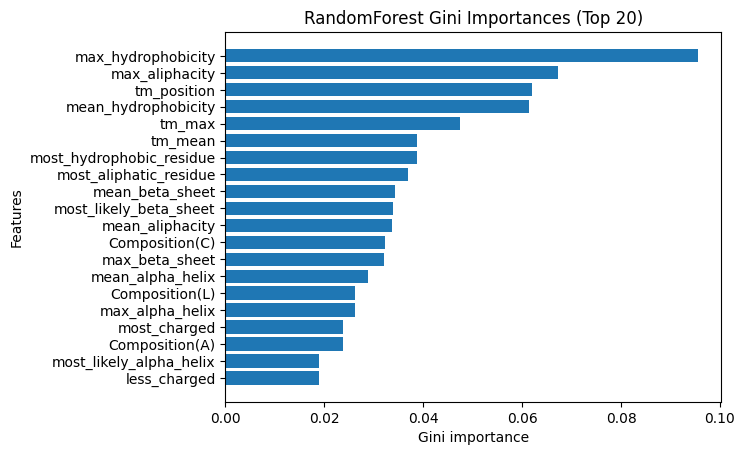

28
Best k on validation (using baseline f1_best params): k=25, val_f1=0.823
Best k on validation (using baseline mcc_best params): k=25, val_mcc=0.802


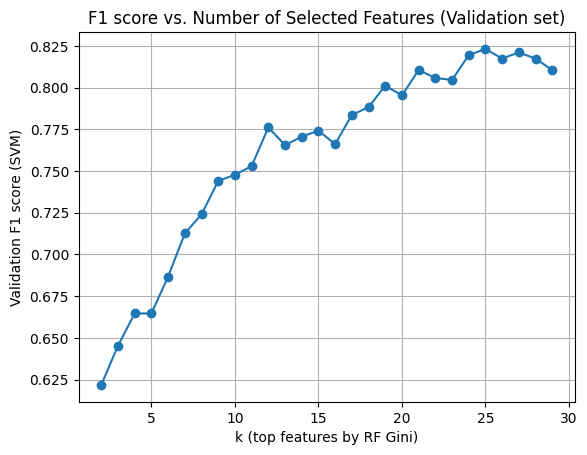

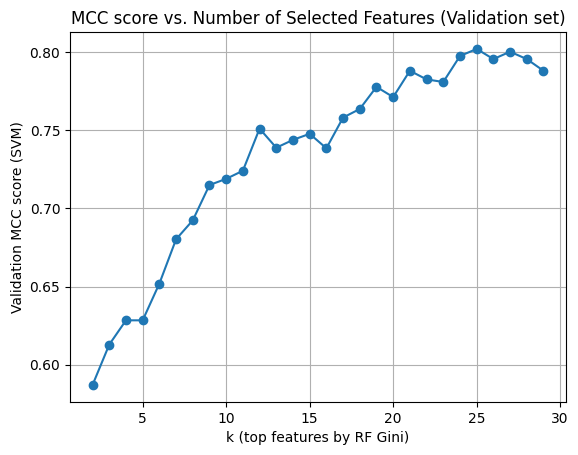

Selected features (best k): {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best validation F1 score on selected features: 0.823 with {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Test F1 score (selected features, tuned on val): 0.840
Selected features (best k): {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation MCC score on selected features: 0.802 with {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Test MCC score (selected features, tuned on val): 0.799
Test F1 score (all features, baseline tuned on val): 0.867
Test MCC score (all features, baseline tuned on val): 0.853


/tmp/ipython-input-24617187.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  training_classes = pd.concat([training_classes, df_training['Class']])


Baseline SVM (all features) — best validation F1 score for round 2 :0.888 with params {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Baseline SVM (all features) — best validation MCC score 2 :0.877 with params {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


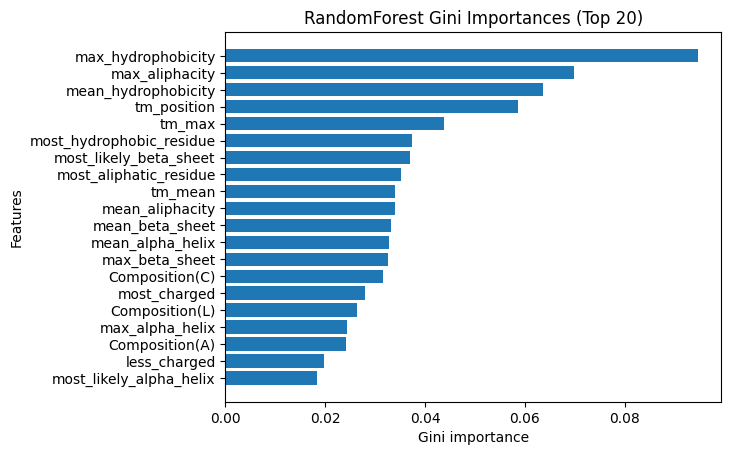

28
Best k on validation (using baseline f1_best params): k=25, val_f1=0.865
Best k on validation (using baseline mcc_best params): k=25, val_mcc=0.849


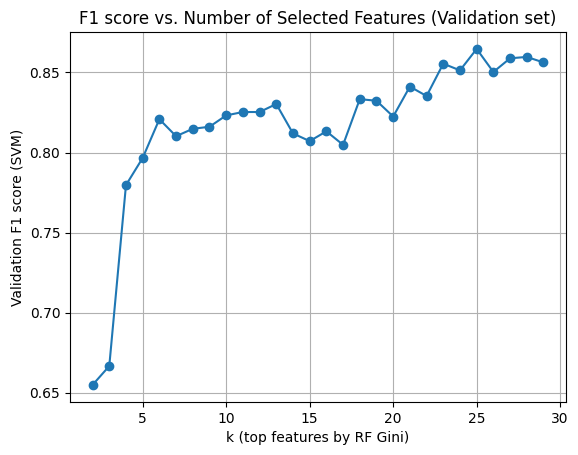

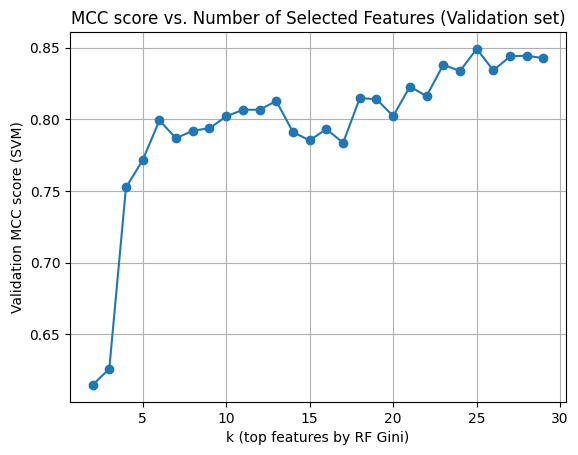

Selected features (best k): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation F1 score on selected features: 0.865 with {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Test F1 score (selected features, tuned on val): 0.798
Selected features (best k): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation MCC score on selected features: 0.849 with {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Test MCC score (selected features, tuned on val): 0.774
Test F1 score (all features, baseline tuned on val): 0.805
Test MCC score (all features, baseline tuned on val): 0.781


/tmp/ipython-input-24617187.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  training_classes = pd.concat([training_classes, df_training['Class']])


Baseline SVM (all features) — best validation F1 score for round 3 :0.841 with params {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Baseline SVM (all features) — best validation MCC score 3 :0.822 with params {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


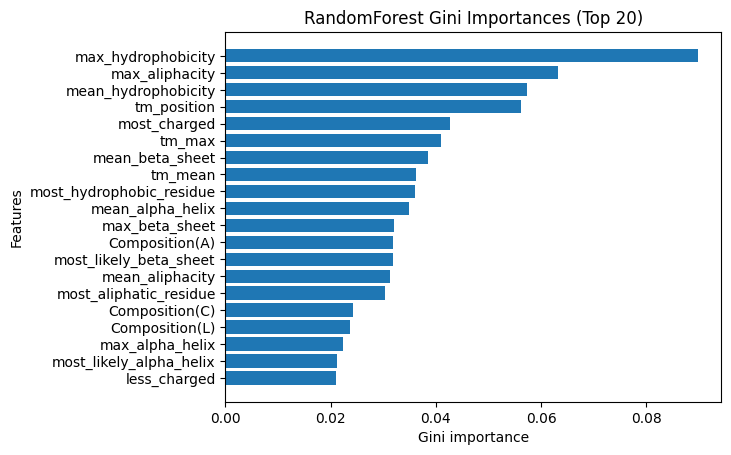

28
Best k on validation (using baseline f1_best params): k=29, val_f1=0.827
Best k on validation (using baseline mcc_best params): k=29, val_mcc=0.807


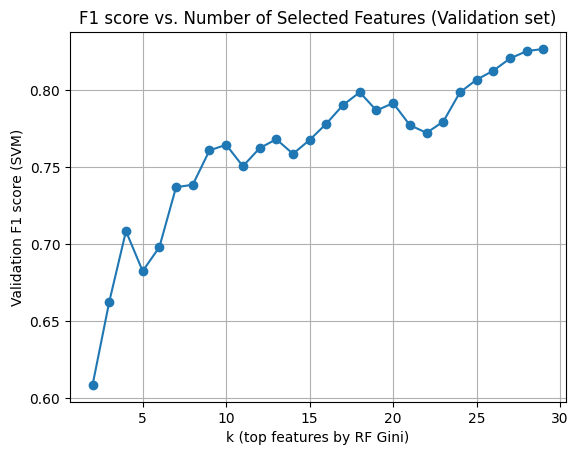

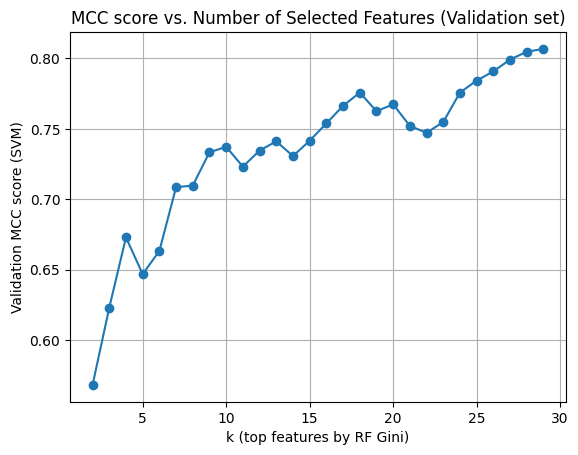

Selected features (best k): {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best validation F1 score on selected features: 0.827 with {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Test F1 score (selected features, tuned on val): 0.841
Selected features (best k): {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best validation MCC score on selected features: 0.807 with {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Test MCC score (selected features, tuned on val): 0.822
Test F1 score (all features, baseline tuned on val): 0.857
Test MCC score (all features, baseline tuned on val): 0.839


/tmp/ipython-input-24617187.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  training_classes = pd.concat([training_classes, df_training['Class']])


Baseline SVM (all features) — best validation F1 score for round 4 :0.861 with params {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Baseline SVM (all features) — best validation MCC score 4 :0.844 with params {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


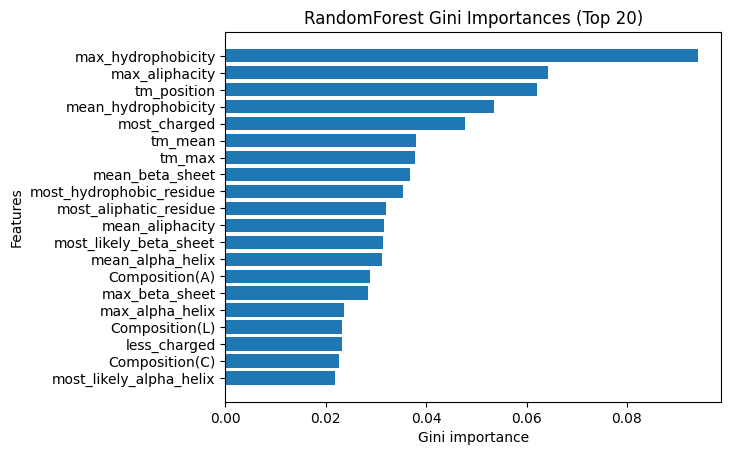

28
Best k on validation (using baseline f1_best params): k=24, val_f1=0.828
Best k on validation (using baseline mcc_best params): k=24, val_mcc=0.807


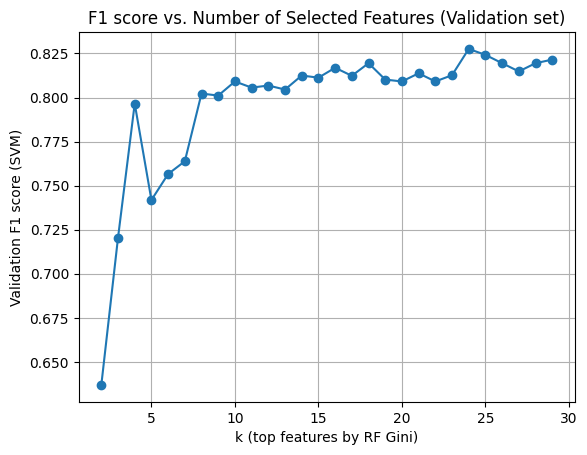

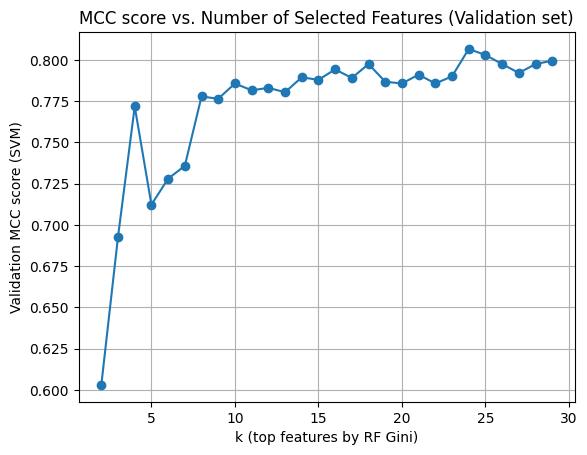

Selected features (best k): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation F1 score on selected features: 0.828 with {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Test F1 score (selected features, tuned on val): 0.838
Selected features (best k): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation MCC score on selected features: 0.807 with {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Test MCC score (selected features, tuned on val): 0.818
Test F1 score (all features, baseline tuned on val): 0.874
Test MCC score (all features, baseline tuned on val): 0.859


/tmp/ipython-input-24617187.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  training_classes = pd.concat([training_classes, df_training['Class']])


Baseline SVM (all features) — best validation F1 score for round 5 :0.872 with params {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Baseline SVM (all features) — best validation MCC score 5 :0.856 with params {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


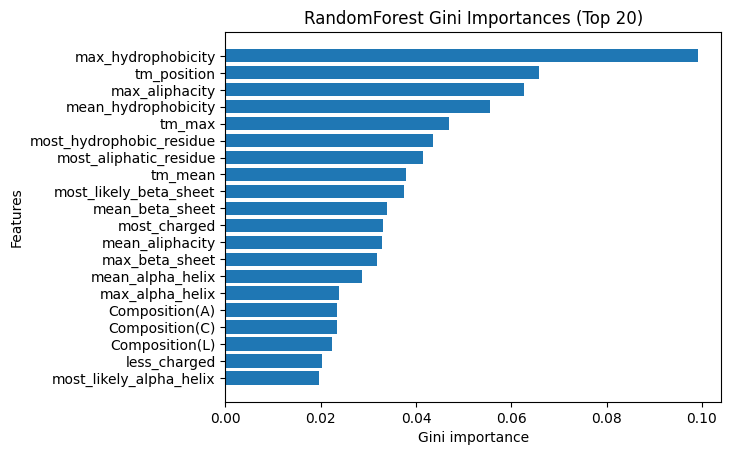

28
Best k on validation (using baseline f1_best params): k=28, val_f1=0.867
Best k on validation (using baseline mcc_best params): k=28, val_mcc=0.850


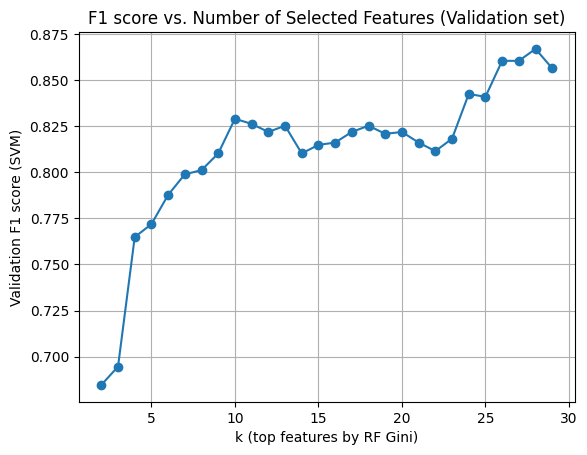

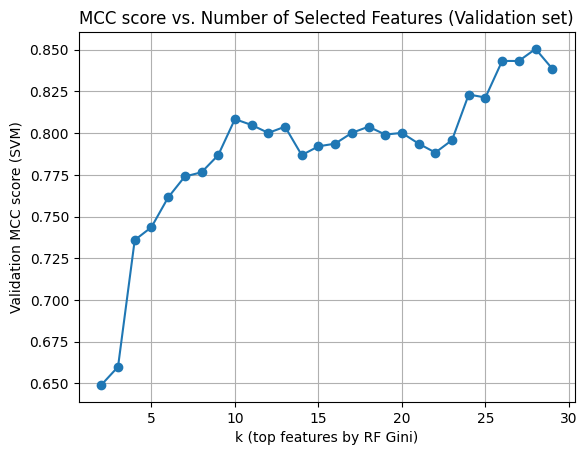

Selected features (best k): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation F1 score on selected features: 0.872 with {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Test F1 score (selected features, tuned on val): 0.813
Selected features (best k): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation MCC score on selected features: 0.857 with {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Test MCC score (selected features, tuned on val): 0.791
Test F1 score (all features, baseline tuned on val): 0.824
Test MCC score (all features, baseline tuned on val): 0.802


In [7]:
feature_names = ([f"Composition({residue})" for residue in "AQLSREKTNGMWDHFYCIPV"] + # 20 aa composition
 ["mean_hydrophobicity", "max_hydrophobicity", "most_hydrophobic_residue",
  "mean_aliphacity", "max_aliphacity", "most_aliphatic_residue", # 6 hydrophobicity and aliphacity
  "tm_mean", "tm_max", "tm_position", # 3 tm propensity features
  "mean_alpha_helix", "max_alpha_helix", "most_likely_alpha_helix",
  "mean_beta_sheet", "max_beta_sheet", "most_likely_beta_sheet", # 6 accounting for SSE
  "max_charge", "most_charged", "min_charge", "less_charged" # 4 accounting for charge
  ])

kernels = ["linear", "rbf", "poly"]
C_grid = [0.1, 1, 10, 100]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

# CREATING PANDAS SERIES FOR SEQUENCES AND CLASSES
df = pd.read_csv("training_df.tsv", sep = "\t")
training,validation,testing = cross_val(5)
for i in range(len(validation)):
    training_sequences = pd.Series([], dtype = object)
    training_classes = pd.Series([], dtype = object)
    validation_sequences = df[df['Label'] == validation[i]]['Frag_90']
    validation_classes = df[df['Label'] == validation[i]]['Class']
    testing_sequences = df[df['Label'] == testing[i]]['Frag_90']
    testing_classes = df[df['Label'] == testing[i]]['Class']
    for el in training[i]:
            df_training = df[df['Label'] == el]
            training_sequences = pd.concat([training_sequences, df_training['Frag_90']])
            training_classes = pd.concat([training_classes, df_training['Class']])
    # Feature Extraction
    training_features = extract_features(training_sequences)
    validation_features = extract_features(validation_sequences)
    testing_features = extract_features(testing_sequences)

    # Feature Scaling
    training_features, validation_features, testing_features = feature_scaler(training_features), feature_scaler(validation_features), feature_scaler(testing_features)

    # Grid on C and Gamma over the validation set

    best_f1 , f1_params = grid_f1(kernels, C_grid, gamma_grid, training_features, training_classes, validation_features, validation_classes)

    print("Baseline SVM (all features) — best validation F1 score for round "+str(validation[i])+" :"
          f"{best_f1:.3f} with params {f1_params}")

    best_mcc , mcc_params = grid_mcc(kernels, C_grid, gamma_grid, training_features, training_classes, validation_features, validation_classes)

    print("Baseline SVM (all features) — best validation MCC score "+str(validation[i])+" :"
          f"{best_mcc:.3f} with params {mcc_params}")

    rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight={0: 9, 1: 1}) # ADDRESSING CLASS UNBALANCE
    rf.fit(training_features, training_classes)  # fit only on TRAIN
    gini_imp = pd.Series(rf.feature_importances_, index = feature_names).sort_values(ascending=False)
    gini_df = gini_imp.reset_index()
    gini_df.columns = ["feature", "importance"]
    #pd.to_csv("Features_gini_"+str(validation[i])+".tsv", sep = "\t", index = False, header = True)

    # Plot top 20
    plt.figure()
    plt.barh(gini_df["feature"].head(20)[::-1], gini_df["importance"].head(20)[::-1])
    plt.xlabel("Gini importance")
    plt.ylabel("Features")
    plt.title("RandomForest Gini Importances (Top 20)")
    plt.show()
    #plt.savefig(f"Features_round{i+1}.pdf", dpi = 1000, format = "pdf", bbox_inches="tight", pad_inches = 0.2)
    #plt.clf()

    ks = list(range(2, min(30, training_features.shape[1]+1)))  # keep it small for speed/clarity
    print(len(ks))
    f1_curve = []
    mcc_curve = []

    for k in ks:
        subset = gini_df["feature"].head(k).tolist()
        f1_k = f1_on_subset(f1_params["C"], f1_params["gamma"], f1_params["kernel"], subset)
        f1_curve.append(f1_k)
        mcc_k = mcc_on_subset(mcc_params["C"], mcc_params["gamma"], mcc_params["kernel"], subset)
        mcc_curve.append(mcc_k)

    f1_k_idx = int(np.argmax(f1_curve))
    f1_bestk = ks[f1_k_idx]
    mcc_k_idx = int(np.argmax(mcc_curve))
    mcc_bestk = ks[mcc_k_idx]
    print(f"Best k on validation (using baseline f1_best params): k={f1_bestk}, val_f1={f1_curve[f1_k_idx]:.3f}")
    print(f"Best k on validation (using baseline mcc_best params): k={mcc_bestk}, val_mcc={mcc_curve[mcc_k_idx]:.3f}")


    plt.figure()
    plt.plot(ks, f1_curve, marker="o")
    plt.xlabel("k (top features by RF Gini)")
    plt.ylabel("Validation F1 score (SVM)")
    plt.title("F1 score vs. Number of Selected Features (Validation set)")
    plt.grid(True)
    plt.show()
    #plt.savefig(f"F1_vs_Val_round{i+1}.pdf", dpi = 1000, format = "pdf", bbox_inches="tight", pad_inches = 0.2)
    #plt.clf()


    plt.figure()
    plt.plot(ks, mcc_curve, marker="o")
    plt.xlabel("k (top features by RF Gini)")
    plt.ylabel("Validation MCC score (SVM)")
    plt.title("MCC score vs. Number of Selected Features (Validation set)")
    plt.grid(True)
    plt.show()
    #plt.savefig(f"MCC_vs_Val_round{i+1}.pdf", dpi = 1000, format = "pdf", bbox_inches="tight", pad_inches = 0.2)
    #plt.clf()

    # Use the best k from the validation curve
    feature_names_np = np.array(feature_names)
    f1_subset = gini_df["feature"].head(f1_bestk).tolist()
    mcc_subset = gini_df["feature"].head(mcc_bestk).tolist()

    f1_idx = [np.where(feature_names_np == f)[0][0] for f in f1_subset]
    mcc_idx = [np.where(feature_names_np == f)[0][0] for f in mcc_subset]


    Xtr_f1 = training_features[:, f1_idx]
    Xva_f1 = validation_features[:, f1_idx]
    Xte_f1 = testing_features[:, f1_idx]

    Xtr_mcc = training_features[:, mcc_idx]
    Xva_mcc = validation_features[:, mcc_idx]
    Xte_mcc = testing_features[:, mcc_idx]

    # Manual grid search again but now restricted to the selected features
    f1_sel, f1_selp = grid_f1(kernels, C_grid, gamma_grid, Xtr_f1, training_classes, Xva_f1, validation_classes)
    mcc_sel, mcc_selp = grid_mcc(kernels, C_grid, gamma_grid, Xtr_mcc, training_classes, Xva_mcc, validation_classes)

    # Train final model on TRAIN+VAL with best params (optional) or just TRAIN; here we keep TRAIN only as per your outline

    final_f1 = svm_pipeline(f1_selp["C"], f1_selp["gamma"], f1_selp["kernel"])
    final_f1 = final_f1.fit(Xtr_f1, training_classes)
    predf1_test = final_f1.predict(Xte_f1)
    test_f1 = f1_score(testing_classes, predf1_test)

    final_mcc = svm_pipeline(mcc_selp["C"], mcc_selp["gamma"], mcc_selp["kernel"])
    final_mcc = final_mcc.fit(Xtr_mcc, training_classes)
    predmcc_test = final_mcc.predict(Xte_mcc)
    test_mcc = matthews_corrcoef(testing_classes, predmcc_test)

    print("Selected features (best k):", f1_selp)
    print("Best validation F1 score on selected features:", f"{f1_sel:.3f}", "with", f1_selp)
    print("Test F1 score (selected features, tuned on val):", f"{test_f1:.3f}")

    print("Selected features (best k):", mcc_selp)
    print("Best validation MCC score on selected features:", f"{mcc_sel:.3f}", "with", mcc_selp)
    print("Test MCC score (selected features, tuned on val):", f"{test_mcc:.3f}")

    # For comparison: test accuracy with all features using baseline best params
    baseline_pipe = svm_pipeline(f1_params["C"], f1_params["gamma"], f1_params["kernel"])
    baseline_pipe.fit(training_features, training_classes)
    baseline_predtest = baseline_pipe.predict(testing_features)
    test_f1_all = f1_score(testing_classes, baseline_predtest)
    print("Test F1 score (all features, baseline tuned on val):", f"{test_f1_all:.3f}")

    baseline_pipe = svm_pipeline(mcc_params["C"], mcc_params["gamma"], mcc_params["kernel"])
    baseline_pipe.fit(training_features, training_classes)
    baseline_predtest = baseline_pipe.predict(testing_features)
    test_mcc_all = matthews_corrcoef(testing_classes, baseline_predtest)
    print("Test MCC score (all features, baseline tuned on val):", f"{test_mcc_all:.3f}")